<a href="https://colab.research.google.com/github/007Anmol/Innovize_ML_npmrundev/blob/main/Innovize_npmrundev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       803
           1       0.98      0.97      0.98       397

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



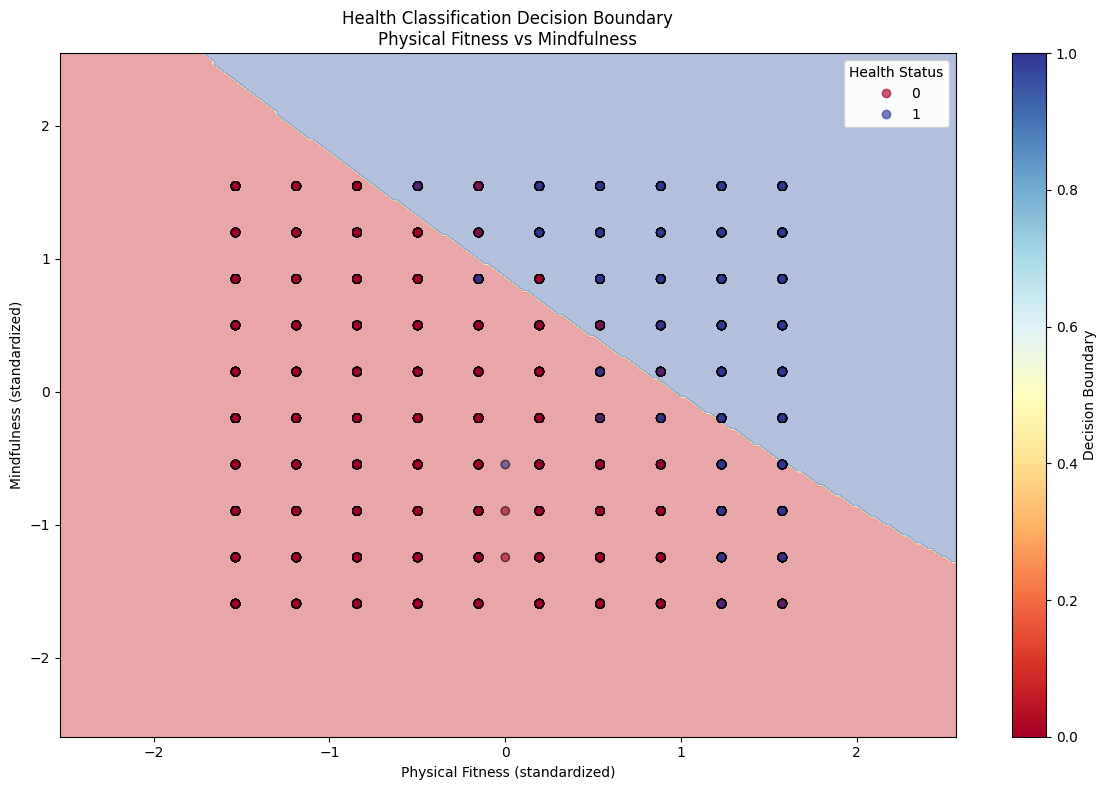

['health_classifier_complete.pkl']

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import joblib


data = pd.read_csv('/content/innovize_final_ml.csv')


categorical_cols = ['diet_pref', 'act_level', 'career']
numerical_cols = ['phy_fitness', 'sleep_hrs', 'mindfulness', 'gender',
                 'daily_avg_steps', 'daily_avg_calories']


numerical_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])


categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])


encoded_cols = []
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    encoded_col = col + '_encoded'
    data[encoded_col] = label_encoders[col].fit_transform(data[col])
    encoded_cols.append(encoded_col)

feature_cols = numerical_cols + encoded_cols
X = data[feature_cols]
y = data['is_healthy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)


y_pred = svm.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

def plot_decision_boundary(data, model, scaler):

    plt.figure(figsize=(12, 8))


    phy_fitness_idx = feature_cols.index('phy_fitness')
    mindfulness_idx = feature_cols.index('mindfulness')


    X_scaled = scaler.transform(data[feature_cols])


    x_min, x_max = X_scaled[:, phy_fitness_idx].min() - 1, X_scaled[:, phy_fitness_idx].max() + 1
    y_min, y_max = X_scaled[:, mindfulness_idx].min() - 1, X_scaled[:, mindfulness_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))


    mesh_points = np.zeros((xx.ravel().shape[0], len(feature_cols)))
    mesh_points[:, phy_fitness_idx] = xx.ravel()
    mesh_points[:, mindfulness_idx] = yy.ravel()


    for i in range(len(feature_cols)):
        if i != phy_fitness_idx and i != mindfulness_idx:
            mesh_points[:, i] = X_scaled[:, i].mean()


    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)


    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')


    scatter = plt.scatter(X_scaled[:, phy_fitness_idx],
                         X_scaled[:, mindfulness_idx],
                         c=data['is_healthy'],
                         cmap='RdYlBu',
                         edgecolor='black',
                         alpha=0.6)

    plt.xlabel('Physical Fitness (standardized)')
    plt.ylabel('Mindfulness (standardized)')
    plt.title('Health Classification Decision Boundary\nPhysical Fitness vs Mindfulness')


    legend1 = plt.legend(*scatter.legend_elements(),
                        loc="upper right", title="Health Status")
    plt.gca().add_artist(legend1)


    plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu'),
                ax=plt.gca(), label='Decision Boundary')

    plt.tight_layout()
    plt.savefig('health_decision_boundary.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_decision_boundary(data, svm, scaler)


model_data = {
    'model': svm,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'numerical_imputer': numerical_imputer,
    'categorical_imputer': categorical_imputer,
    'categorical_cols': categorical_cols,
    'numerical_cols': numerical_cols,
    'feature_cols': feature_cols
}
joblib.dump(model_data, 'health_classifier_complete.pkl')